**Проект сделан для анализа инвестиций развлекательного приложения Procrastinate Pro+ в рекламу.** Так как компания несет убытки при больших инвестициях в продвижение, нужно рассмотреть, насколько целеесообразно распределен бюджет. Цель работы - найти пробелы и недочеты в инвестиционном плане  и выяснить, нужно ли его менять и куда стоит вложить средства. Для этого нужно будет изучить:

    откуда приходят пользователи и какими устройствами они пользуются,
    сколько стоит привлечение пользователей из различных рекламных каналов;
    сколько денег приносит каждый клиент,
    когда расходы на привлечение клиента окупаются,
    какие факторы мешают привлечению клиентов.
    
Данные для анализы предоставлены компанией Procrastinate Pro+ за период с 1 мая по 27 октября 2019 года.

1. [Открытие данных](#start)
2. [Предобратотка данных](#1)
   * [обработка первого датасета](#d1)
   * [обработка второго датасета](#d2) 
   * [обработка третьего датасета](#d3)
3. [Собираю функции](#2)
   * [функция для создания пользовательских профилей](#f1)
   * [функция для расчёта удержания](#f2) 
   * [функция для расчёта конверсии](#f3)
   * [функция для расчёта LTV и ROI](#f4)
   * [функция для сглаживания фрейма](#f5) 
   * [функция для визуализации удержания](#f6)
   * [функция для визуализации конверсии](#f7)
   * [функция для визуализации LTV и ROI](#f8)
4. [Исследовательский анализ данных](#3)
   * [Даты привлечения](#3.1)
   * [Анализ по странам](#3.2) 
   * [Анализ по устройствам](#3.3)
   * [Анализ по каналам привлечения](#3.4)
5. [Маркетинг](#4)
   * [Общая сумма расходов на маркетинг](#4.1)
   * [Траты по рекламным источникам](#4.2) 
   * [Динамика изменения расходов](#4.3)
   * [Средняя стоимость привлечения](#4.4)
6. [Окупаемость рекламы](#5)
   * [Общая окупаемость рекламы](#5.1)
   * [Конверсия и удержание](#5.2) 
   * [Окупаемость по устройствам](#5.3)
   * [Окупаемость по странам](#5.4)
   * [Окупаемость по каналам](#5.5) 
   * [Окупаемость США](#5.6)
   * [Вывод по окупаемости](#5.7)
7. [Вывод и рекомендации](#6)

### Загрузите данные и подготовьте их к анализу

**Открытие данных**
<a id="start"></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
visits = pd.read_csv('...')
orders = pd.read_csv('...')
costs = pd.read_csv('...')
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


**Предобработка данных**
<a id="1"></a>

Буду обрабатывать каждый датасет по очереди. Начну с датасета visits.
<a id="d1"></a>

In [2]:
visits.columns = ['user_id','region','device','channel','session_start','session_end']
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [3]:
visits.isna().sum()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

In [4]:
visits.duplicated().sum()

0

Обрабатываю давасет orders
<a id="d2"></a>

In [5]:
orders.columns = ['user_id','event_dt', 'revenue']
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders.isna().sum()
orders.duplicated().sum()

0

Обрабатываю датасет costs
<a id="d3"></a>

In [6]:
costs.columns = ['dt', 'channel', 'costs']
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 
#costs['dt'] = costs['dt'].astype('datetime64[W]')
costs.isna().sum()
costs.duplicated().sum()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Можно заметить отсутствие дубликатов и пропущенных значений в датасетах.

### Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.
<a id="2"></a>

Разрешается использовать функции, с которыми вы познакомились в теоретических уроках.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

Функция для создания пользовательских профилей
<a id="f1"></a>

In [7]:
# функция для создания пользовательских профилей
def get_profiles(visits, orders, ad_costs):
    profiles = (visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg({'session_start': 'first','channel': 'first', 'device': 'first', 'region': 'first',})
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    return profiles

Функция для расчёта удержания
<a id="f2"></a>

In [8]:
# функция для расчёта удержания
def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    dimensions = ['payer'] + dimensions
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days=horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(visits[['user_id', 'session_start']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    
    
        
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        #result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns={'user_id': 'cohort_size'}))
        
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    return result_raw, result_grouped, result_in_time                               

Функция для расчёта конверсии
<a id="f3"></a>

In [9]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    first_purchases = (purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index())
    result_raw = result_raw.merge(first_purchases[['user_id', 'event_dt']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
        index=dims, columns='lifetime', values='user_id', aggfunc='nunique')
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
        df.groupby(dims)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'}))
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    if 'cohort' in dimensions: 
        dimensions = []
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days)
    return result_raw, result_grouped, result_in_time

Функция для расчёта LTV и ROI
<a id="f4"></a>

In [10]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left')
    result_raw['lifetime'] = (result_raw['event_dt'] - result_raw['first_ts']).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
        index=dims, columns='lifetime', values='revenue', aggfunc='sum')
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'}))
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'}))
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days)
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

**Функции для визуализации этих метрик**

Функция сглаживания фрейма
<a id="f5"></a>

In [11]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

Функция для визуализации удержания
<a id="f6"></a>

In [12]:
# функция для визуализации удержания
def plot_retention(retention, retention_history, horizon, window=7):
    plt.figure(figsize=(15, 10))
    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]]
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')
    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']]
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания платящих пользователей на {}-й день'.format(horizon))
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика удержания неплатящих пользователей на {}-й день'.format(horizon))
    plt.tight_layout()
    plt.show() 

Функция для визуализации конверсии
<a id="f7"></a>

In [13]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    plt.figure(figsize=(15, 5))
    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[[horizon - 1]]
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [name for name in conversion_history.index.names if name not in ['dt']]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean')
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 


Функция для визуализации LTV и ROI
<a id="f8"></a>

In [14]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    plt.figure(figsize=(20, 10))
    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    cac_history = roi_history[['cac']]
    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[[horizon - 1]]
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

- Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
- Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сформулируйте выводы.
<a id="3"></a>

In [15]:
profiles = get_profiles(visits, orders, costs)
print(profiles.head(5)) 

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


*Минимальные/ максимальные даты привлечения*
<a id="3.1"></a>

In [16]:
display(profiles['first_ts'].max())
profiles['first_ts'].min()

Timestamp('2019-10-27 23:59:04')

Timestamp('2019-05-01 00:00:41')

Как мы можем увидеть, минимальная дата относится к 1 мая 2019, а самая поздняя к 27 октября 2019.

*Анализ по странам*

<a id="3.2"></a>

In [17]:
#pp = profiles.groupby('region').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)
pay_profiles = profiles.query('payer==True')
#ps = pay_profiles.groupby('region').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)
#k = pp.merge(ps, on='region', how='left')
#k['cov'] = k['user_id_y']/k['user_id_x']*100
#k = k.rename(columns={'user_id_x': 'количество пользователей', 'user_id_y': 'количество платящих пользователей'})


In [18]:
def pay_cov(column):
     return (profiles.groupby(column)
     .agg({'user_id': 'count',
           'payer':'mean',})
     .sort_values(by = 'user_id',
                  ascending = False))
 
region = pay_cov('region')
region['payer'] = region['payer'].apply(lambda x: '{:.2%}'.format(x))
region.sort_values(by='payer', ascending=False)

,user_id,payer
region,,
United States,100002,6.90%
Germany,14981,4.11%
UK,17575,3.98%
France,17450,3.80%


Как мы можем увидеть, что общее количество пользователей прямо пропорционально количеству платящих в странах. Самое большое количество пользователей в Америке равное 100002 пользователей и 6902 тех, кто платит за пользование приложением. Наименьшее количество пользователей в Германии, с 14981 клиентов и 616 платящих пользователей. Ситуация с долями платящих клиентов в Соединенных Штатах равна почти 7%,в Германии чуть больше 4 процентов, в Англии почти 4%, во Франции 3.8 процентов.

*Анализ по устройствам*
<a id="3.3"></a>

In [19]:
def pay_cov(column):
     return (profiles.groupby(column)
     .agg({'user_id': 'count',
           'payer':'mean',})
     .sort_values(by = 'user_id',
                  ascending = False))
 
device = pay_cov('device')
device['payer'] = device['payer'].apply(lambda x: '{:.2%}'.format(x))
device.sort_values(by='payer', ascending=False)

,user_id,payer
device,,
Mac,30042,6.36%
iPhone,54479,6.21%
Android,35032,5.85%
PC,30455,5.05%


Анализируя то, какими устройствами пользуются клиенты, мы можем увидеть что наибольшая доля среди платящих пользователей принадлежит владельцам  Mac и iPhone, с результатами 6.36 и 6.21 процентов, в то время как наименьший результат принадлежит устроствам PC с результатом чуть больше 5 процентов./

*Анализ по каналам привлечения*
<a id="3.4"></a>

In [20]:
def pay_cov(column):
     return (profiles.groupby(column)
     .agg({'user_id': 'count',
           'payer':'mean',})
     .sort_values(by = 'user_id',
                  ascending = False))
 
channel = pay_cov('channel')
channel['payer'] = channel['payer'].apply(lambda x: '{:.2%}'.format(x))
channel.sort_values(by='payer', ascending=False)

,user_id,payer
channel,,
TipTop,19561,9.60%
RocketSuperAds,4448,7.91%
WahooNetBanner,8553,5.30%
YRabbit,4312,3.83%
MediaTornado,4364,3.57%
LeapBob,8553,3.06%
OppleCreativeMedia,8605,2.71%
organic,56439,2.06%
FaceBoom,29144,12.20%


In [21]:
pay_profiles.groupby('channel').agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)

,user_id
channel,
FaceBoom,3557
TipTop,1878
organic,1160
WahooNetBanner,453
AdNonSense,440
RocketSuperAds,352
LeapBob,262
OppleCreativeMedia,233
lambdaMediaAds,225


Анализируя каналы привлечения, мы можем увидеть, что больше всего платящих пользователей пришли с источника FaceBoom,где доля платящих составила 12.20% процентов и канал TipTop, где доля платящих составила 9.60%. Количество оргинических пользователей составляет 56439, где доля покупателей составила 2.06 процентов.

### Маркетинг

- Посчитайте общую сумму расходов на маркетинг.
- Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
- Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

Напишите промежуточные выводы.
<a id="4"></a>

Вычисляю общий объем инвестиций
<a id="4.1"></a>

In [22]:
costs['costs'].sum()

105497.30000000002

Общая сумма затрат на маркетинг с 27 декабря по 1 мая равны 105497.3.

*Распределение трат по источникам*
<a id="4.2"></a>

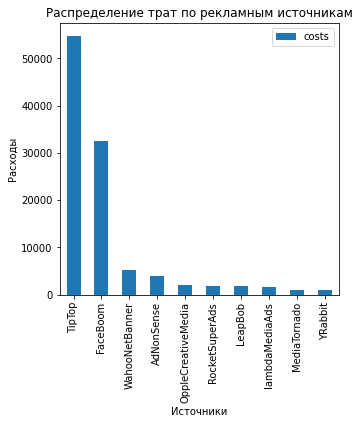

In [23]:
bar = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)
bar.plot(kind='bar', figsize=(5,5))
plt.title('Распределение трат по рекламным источникам')
plt.xlabel('Источники')
plt.ylabel('Расходы')
plt.show()

Как мы можем заметить, наибольшее количество выделенных на каналы привлечения средств приходится на  TipTop, FaceBoom и WahooNetBanner с результатами 54751.3, 32445.6 и 5151 соответственно. 

*Изменение расходов по неделям и месяцам*
<a id="4.3"></a>

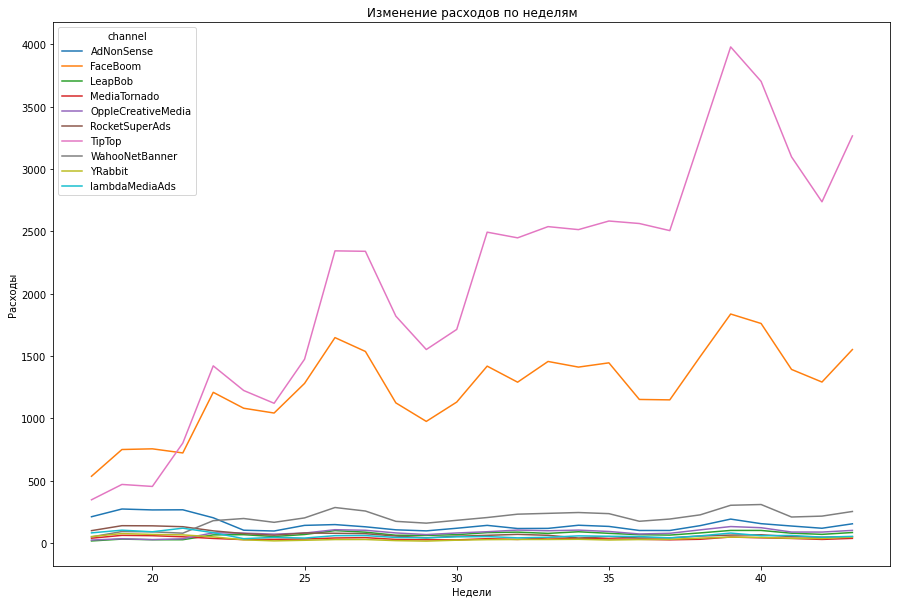

In [26]:
costs['for_reduction'] = pd.to_datetime(costs['dt'])
costs['week'] = costs['for_reduction'].dt.isocalendar().week
costs['month'] = costs['for_reduction'].dt.month
week = costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
week.plot(figsize=(15, 10))
plt.title('Изменение расходов по неделям')
plt.xlabel('Недели')
plt.ylabel('Расходы')
plt.show()

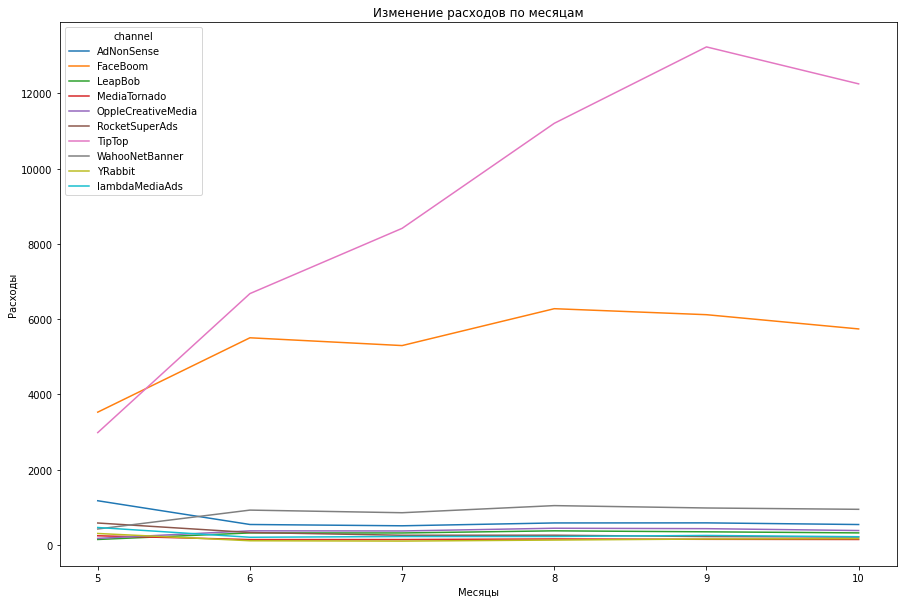

In [27]:
month = costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')
month.plot(figsize=(15, 10))
plt.title('Изменение расходов по месяцам')
# Добавить подписи осей и легенду
plt.xlabel('Месяцы')
plt.ylabel('Расходы')
plt.show()

*мне пришлось создать столбец for_reduction потому что тип данных, в который я перевела cost['dt'] не позволял пойти по тому плану, который я предполагала тут должен быть, но если я меняла тип данных, то у меня переставала работать функция, поэтому я надеюсь такой выход из ситуации позволителен*
Анализируя полученные графики, 

*CAC по каждому источнику*
<a id="4.4"></a>

In [28]:
profiles.groupby('channel').agg({'acquisition_cost': 'mean'}).sort_values(by='acquisition_cost', ascending=False)

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


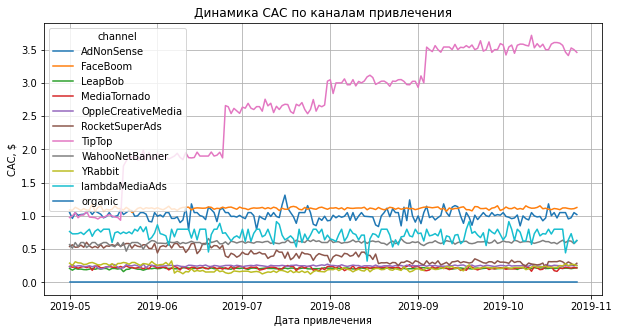

In [29]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

На основе полученного столбца acquisition_cost в профилях пользователей, мы можем увидеть что больше всего средств требуется чтобы привлечь пользователя через источник TipTop(требуется 2.8) и FaceBoom(с суммой 1.113).

На основе полученной диаграмы, мы можем увидеть, что стоимость привлечения клиентов через канал TipTop значительно увеличилась в течение рассматриваемого года в отличие от других каналов.



### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.

- Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
- Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответьте на такие вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?

Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.
<a id="5"></a>

In [30]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14 # горизонт анализа 

Чтобы оценить окупаемость рекламы, исключу органических пользователей.

In [31]:
profiles = profiles.query('channel != "organic"')

Общая окупаемость рекламы с помочью графиков LTV и ROI
<a id="5.1"></a>

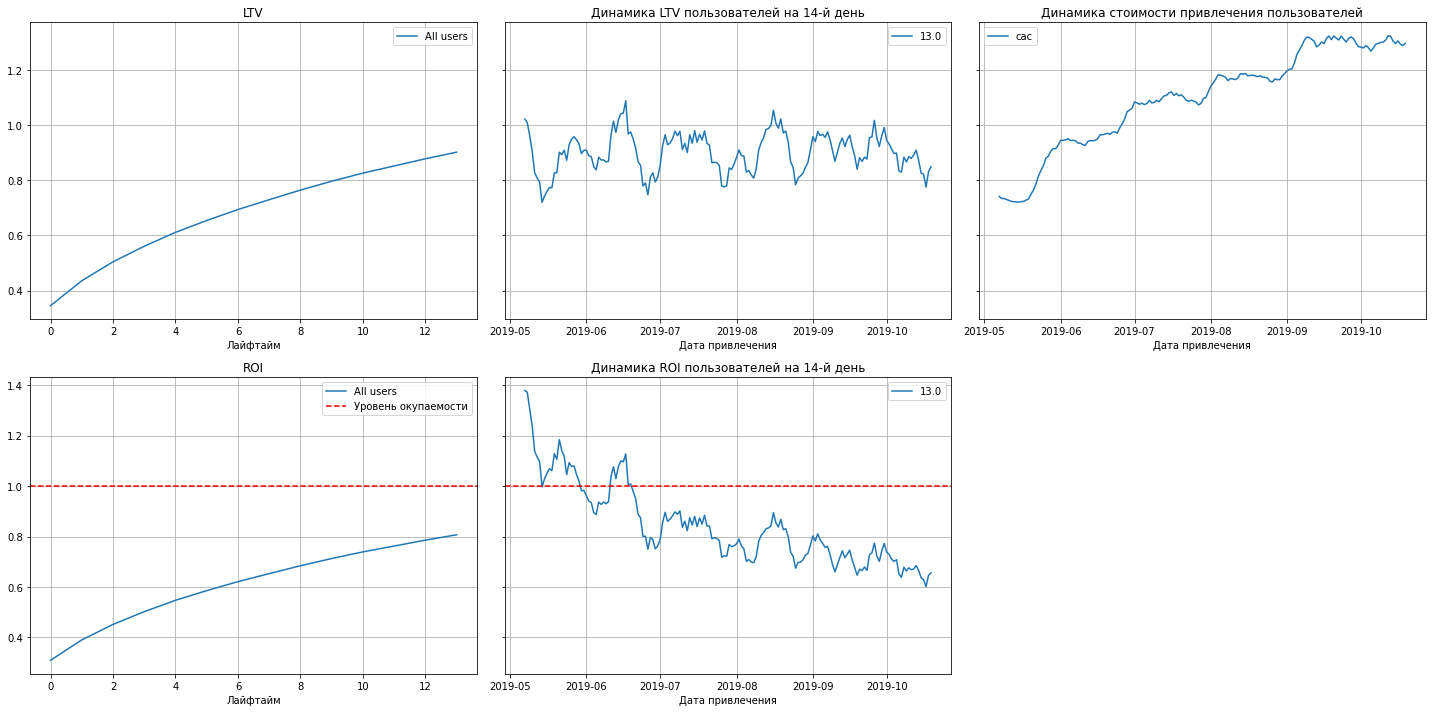

In [32]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**Как показывают получившиеся графики, реклама не окупается. На конец года показатель приближается к 80 процентам. ROI пользователей на 14 перестала окупаться после середины июня. Стоимость привлечения клиента является нестабильной величиной, имеет тенденцию на увеличение. Сумма денег, которую приносит один пользователь имеет скачкообразный характер каждый месяц, никакой сезонности отметить нельзя.**

Конверсия пользователей и динамика изменений
<a id="5.2"></a>

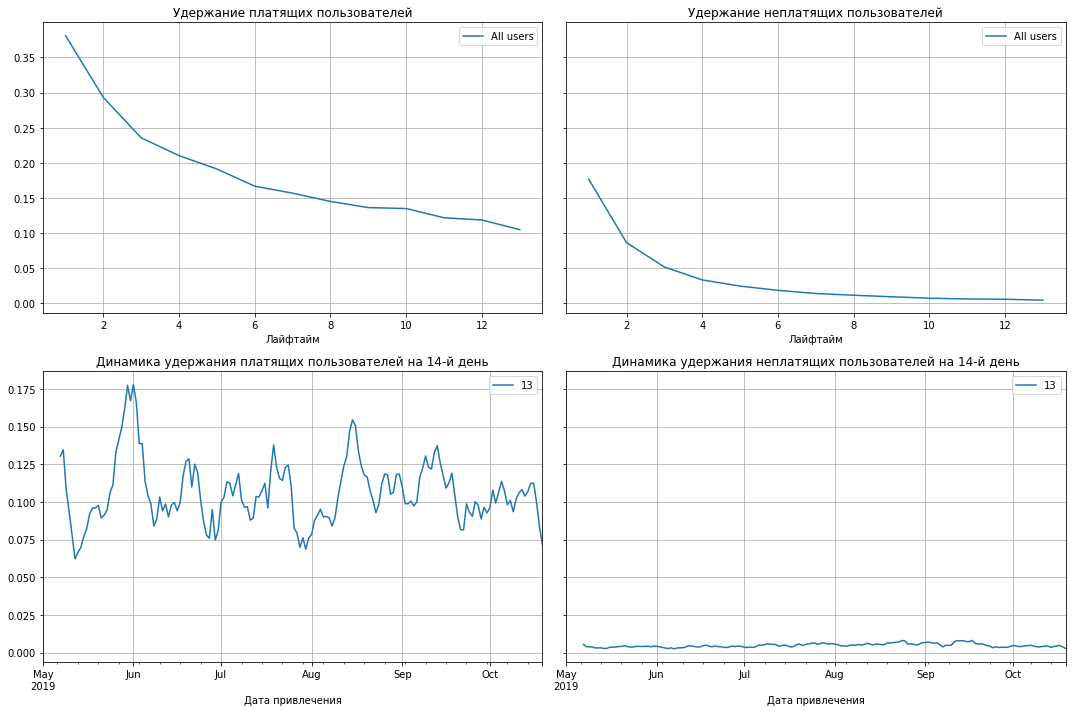

In [33]:
dimensions = []
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

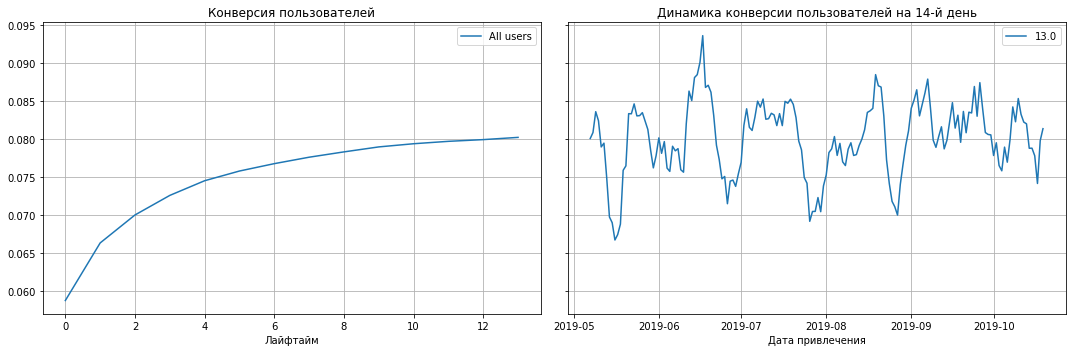

In [34]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Как видно на получившихся граффиках с анализом платящих и неплатящих пользователей, оба вида пользователей стабильно удержтваются, хотя и очевижно те, кто платят, имеют более выразительную динамику. В динамике удержания платящих пользователей на 14 день можно увидеть всплеск в августе, относительно неплатящих пользователей выдающихся значений нельзя отметить. 

Анализируя конверсию пользователей, мы можем увидеть, что хоть и в первые 6 лайфтаймов пользователи и больше конвертируются, чем в течение остального промежутка, но все же график показывает хорошие показатели.

Могу сделать вывод, что вряд ли причиной неокупаемости является ухудшение качества пользователей.Нужно разбираться в качестве и объемах инвестиций.

Как видно на получившихся графиках, конверсия у рассматриваемого приложения довольно хорошая, так как к 14 лайфтайму чуть больше 80 процентов клиентов совершают необходимые нам действия, однако относительно удержания картина не такая хорошая. Мы может увидеть что процент удержания в течение лайфтайма падает с примерно 37 до 10 процентов. Нужно более подробно разобраться в причинах таких низких показателей.

*Окупаемость рекламы по устройствам*
<a id="5.3"></a>

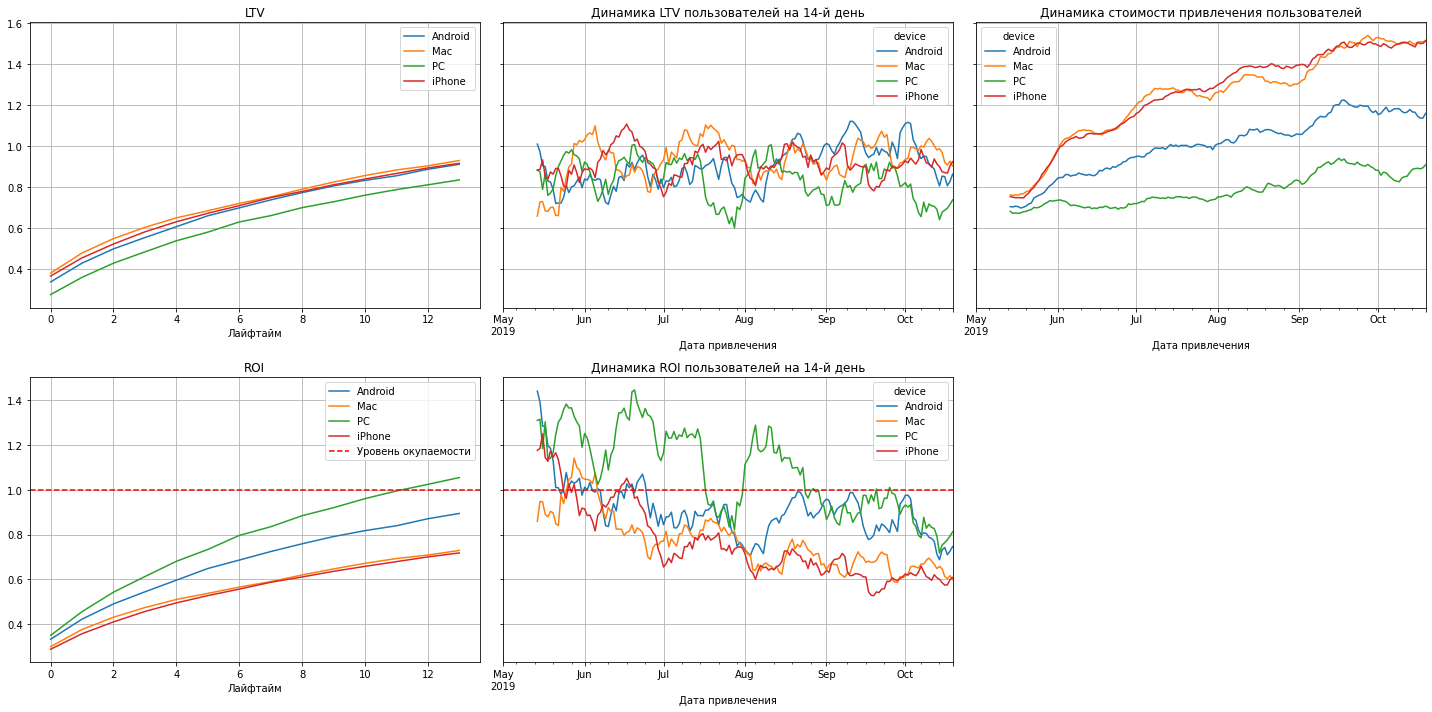

In [35]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По данных графикам можно заметить, что в целом все устройства имеют стабильную динамику по LTV, явных аутсайдеров нет, но все же пользователи pc приносят меньше средств со своих покупок. Динамика стоимости привлечения одного пользователя показывает, что клиентов с Mac и iPhone привлекать стало значительно дороже, чем других пользователей. В итоге именно эти устройства имеют самую большую неокупаемость когда только пользователи PC единственные перешли границу окупаемости.

*Окупаемость по странам*
<a id="5.4"></a>

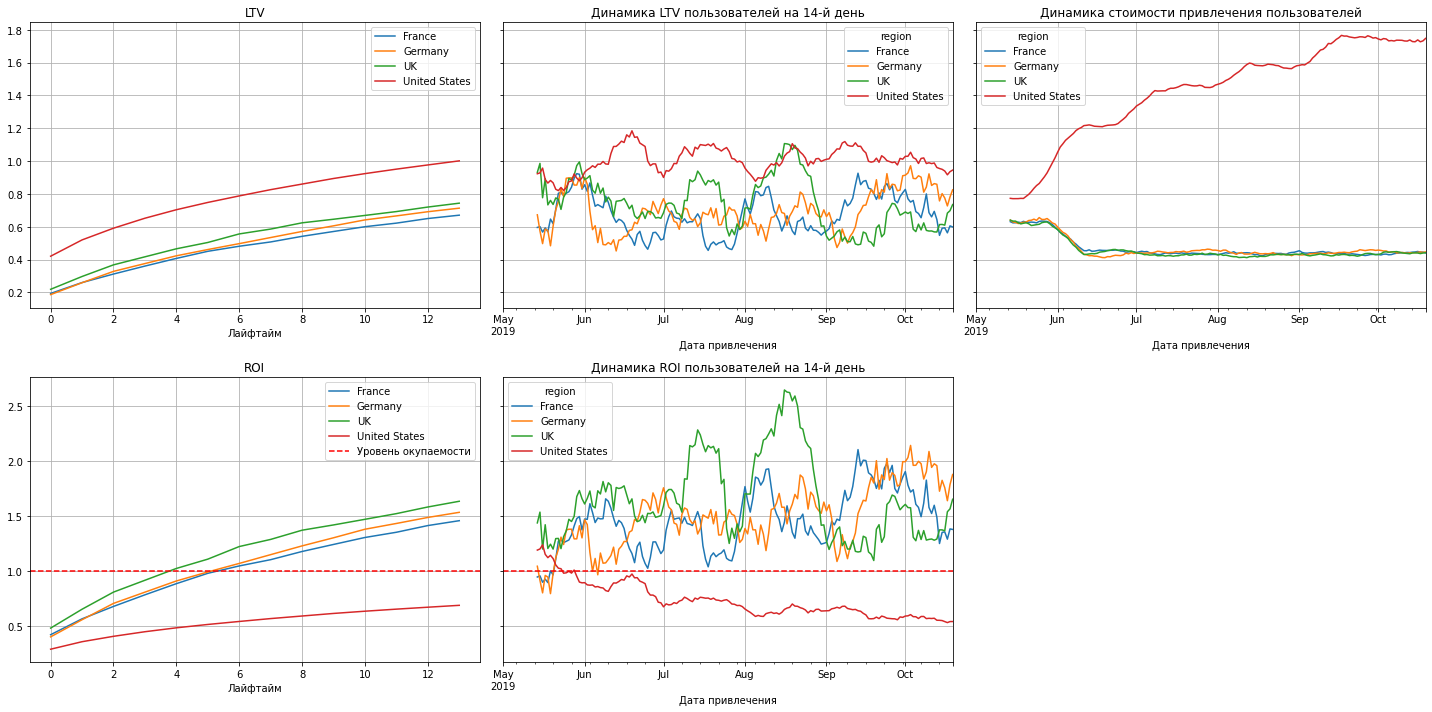

In [36]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Анализируя полученные графики с разбивкой по регионам, мы можем отметить Соединенные Штаты как кагорту пользователей с наивысшим LTV, но при этом самой высокой стоимостью привлечения клиентов. Америка является единственой страной относительно которой можно заметить неокупаемость. Остальные страны в целом имеют примерно одинаковый объем приносимых в компанию инвестиций, стоимость привлечения и окупаемость.

*Окупаемость по каналам привлечения*
<a id="5.5"></a>

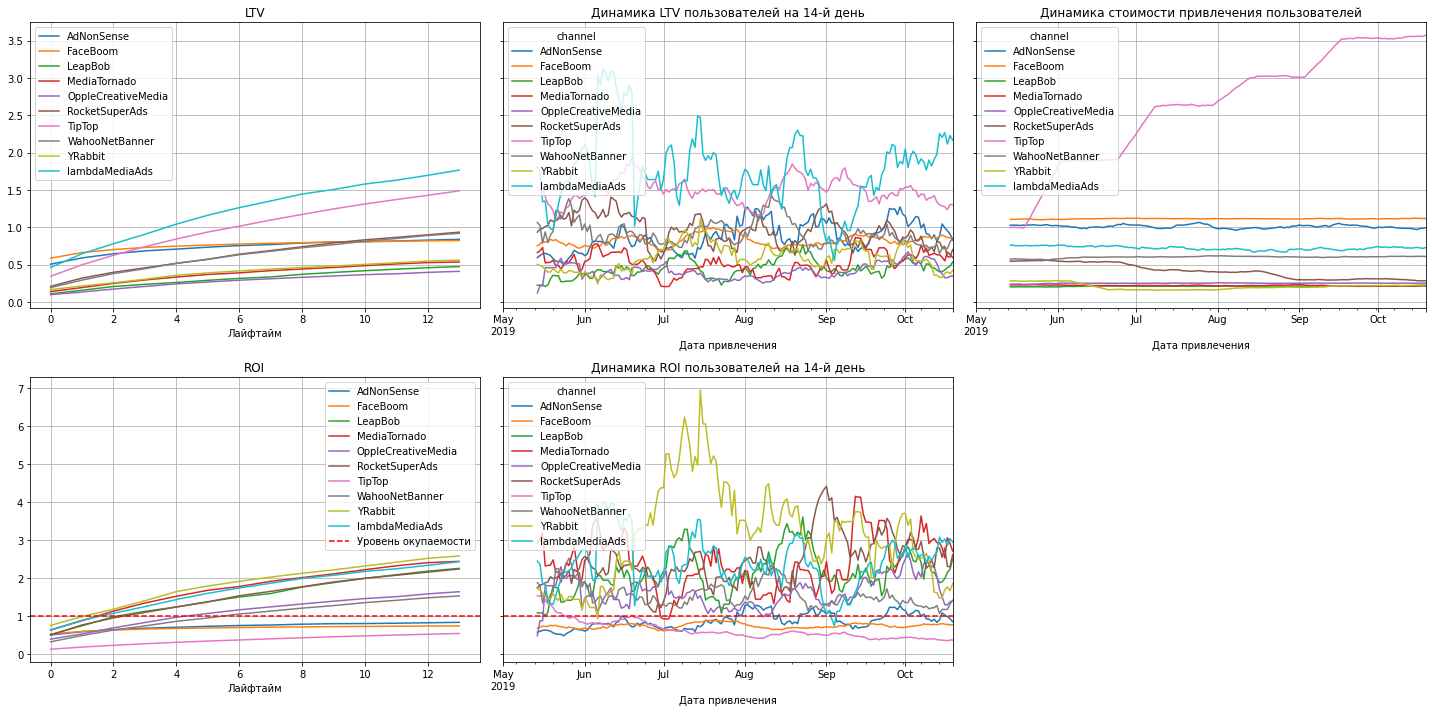

In [37]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Как показывают графики, наибольшые средства в компанию приносит пользователь через канал lambdaMediaAds и TipTop, у последнего из которых САС увеличивается в большей степени в течение последнего года, что и ведет к самой низкой окупаемости среди всех каналов. Самая высокая окупаемость отслеживается у MediaTornado и YRabbit и lambdaMediaAds.

Так как клиенты из США являются подавляющим большинством аудитории приложения, стоит подробнее рассмотреть, где именно возникают сложности.
<a id="5.6"></a>

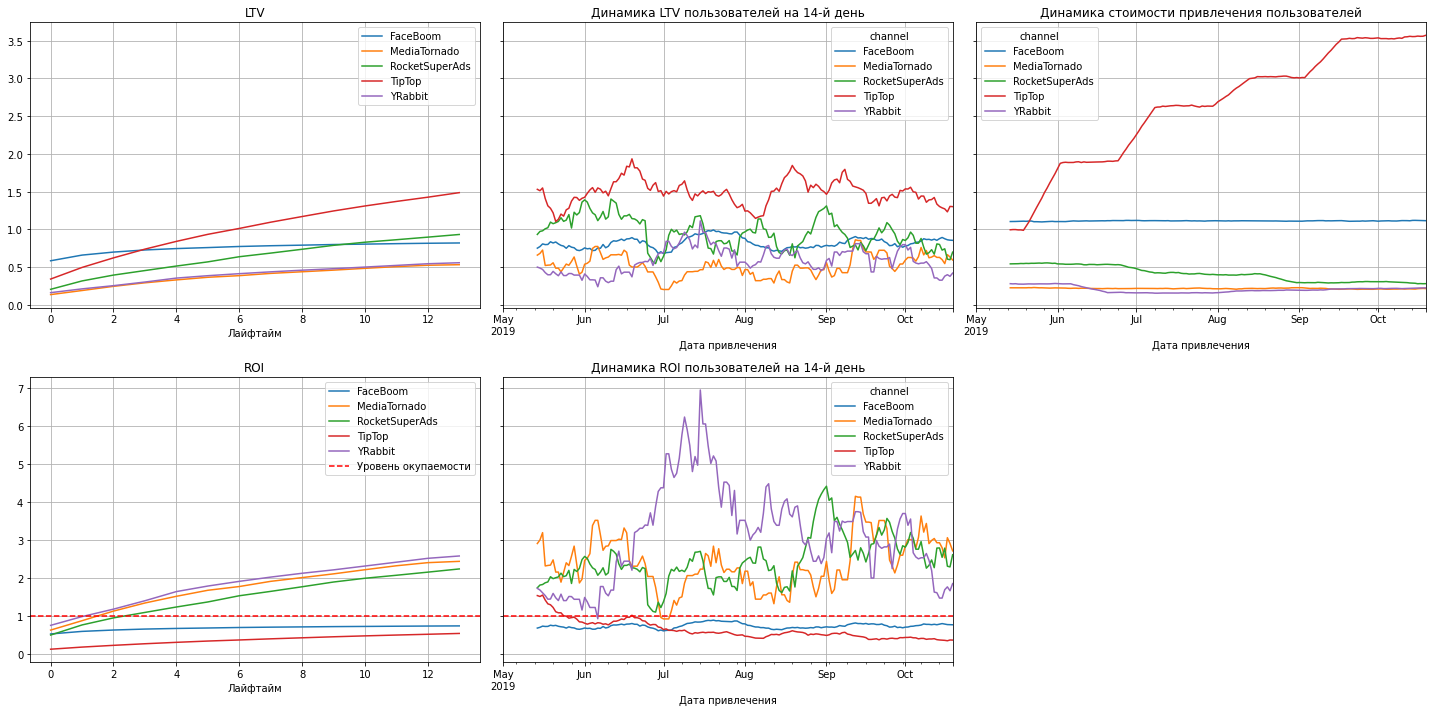

In [38]:
profilies = profiles.query('region == "United States"')
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profilies, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

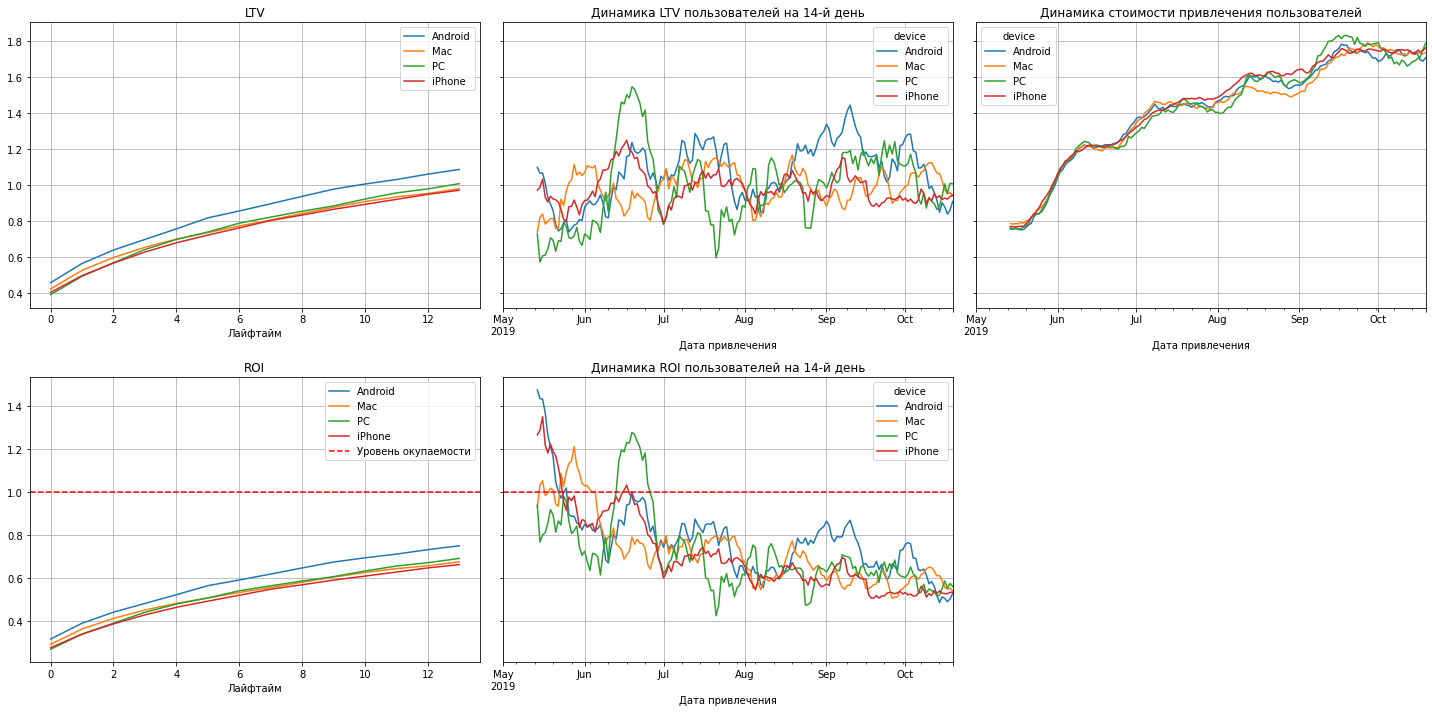

In [39]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profilies, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Можем заметить, что разбивая пользователей по девайсам, клиенты из США стабильно не окупаются.Что касается каналов привлечения, окупаются YRabbit, RocketSuperAds и MediaTornado. 

**Выводы по акупаемости**
<a id="5.7"></a>

Оценив все показатели полученные выше, можно придти к выводу, что в целом реклама не окупается, показатель ROI равен 80%.

К странам, оказывающим негативное влияние по показатели,можно отнести США, стоимость привлечения одного клиента оттуда стоит в разы дороже, чем в остальных странах, что влияет на метрику. Среди девайсов в целом нет аутсайдеров, однако стоит учитывать, что привлечение пользователей Mac и iPhone выходит дороже для компании, хоть их ltv не сильно отличается от других устройств, из-за чего страдает прказатель окупаемости. Среди каналов привлечения TipTop оказывает наибольшее влияние на окупаемость из-за выдающихся показателей cac.

Я могу придти к выводу, что стоит перераспределить инвестиции Проблема вряд ли в общем ухудшении качества клиентов. Проблема может быть в том, что некоторые каналы привлечения и страны обходятся слишком дорого ля компании, из-за повышения стоимости привлеечения в течение всего года. Также разработчикам стоит рассмотреть шанс ошибок в приложении у пользователей мак и айфон.
Нужно будет пересмотреть вложения в Tiptop так как на данный момент это самый дорогой канал привлечения, из-за чего он не окупается. Также нужно рассмотреть канал FaceBoom подробнее, так как это еще один источник, который не переходит границу окупаемости.

Построю удержание по каналам, чтобы оценить качество пользователей.

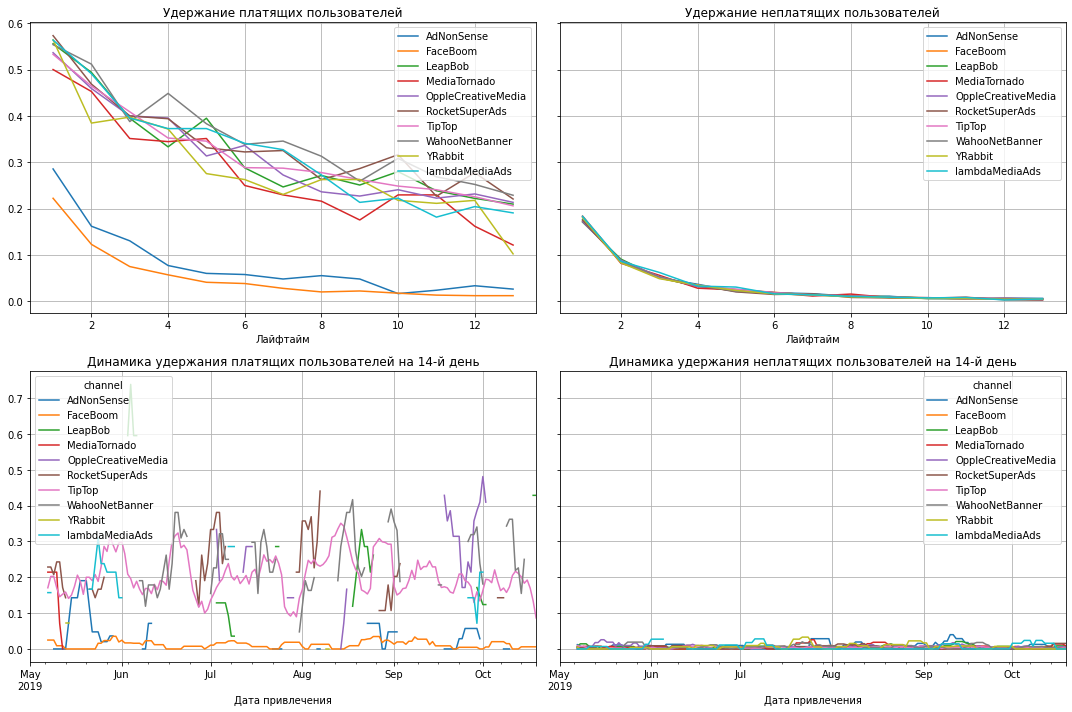

In [40]:
dimensions = ['channel']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Проанализировав канал FaceBoom отдельно и его показатели во всх графиках выше, можно отметить, что он имеет достаточно стабильную стоимость привлечения клиентов и ltv, однако ояень низкое удержание платящих пользователей относительно других каналов привлечения, а значит этот источник приводит платящих клиентов низкого качетсва.


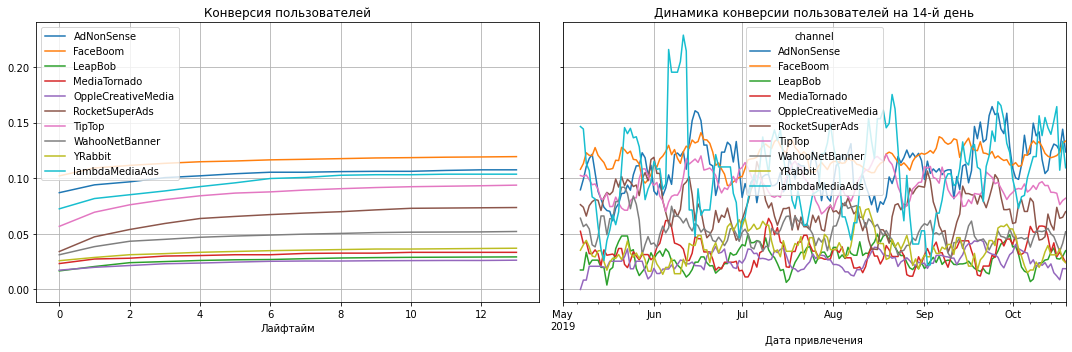

In [41]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days, dimensions = dimensions)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

### Напишите выводы

- Выделите причины неэффективности привлечения пользователей.
- Сформулируйте рекомендации для отдела маркетинга.
<a id="6"></a>

**Реклама приложения, которое мы изучаем, не окупается, поэтому нужно найти гэпы в маркетинговом плане. Касаемо неэффективности привлечения пользователей, я могу отметить неправильное распределение средств среди каналов привлечения пользователей к приложению Procrastinate Pro+. Канал Tiptop имеет не самый высокий LTV, но при этом самую большую стоимость привлечения для компании, однако самые большие вложения идут именно в этот канал, что конечно идет в ищерб компании. Аналогичная ситуация складывается с источником под названием FaceBoom, которая также не окупается в общем и  среди клиентов США. Также стоит обратить внимание на пользователей из США, которые не являются окупаемыми, хоть их пропорция самая большая среди клиентов. Также стоит исключить вероятнотность ошибки в программе на мас и iphone.**

**Теперь, проанализировав все наши результаты, можно дать несколько рекомендаций:**
1. Перераспределить инвестиции между каналами привлеччения. Стоит присмотреться к каналам lambdaMediaAds, так как при средней стоимости привлечения клиентов он имеет самый большой объем денег, который один клиент в среднем приносит компании со всех своих покупок.Также по этим же причинам стоит рассматреть RocketSuperAds и YRabbit.
2. Стоит поработать над наращиванием аудитории в других странах, в особенности над Англией и Германией, чтобы нейтрализовать неокупаемость приложения в США. 
3. Передать разработчикам информацию об отстающих показателях среди клиентов с мас и iphone, чтобы они устранили вероятность ошибки в приожении на этих устройствах.
4. Что касается инвестиций США, стоит найти новые источники для рекламы в этой стране или перераспределить инвестиции в другие каналы, указанные в пункте 1(для Америки актуальны RocketSuperAds, YRabbit и MediaTornado), так как TipTop не окупается из-за высокой стоимостит привлечения, а FaceBoom отличается низким уровнем удержания пользователей.Однако у них самая высокая конверсия среди всех каналах. Похожую ситуацию имеет канал привлечения AdNonSense с высокой конверсией и низким удержанием. 
    Можно попробовать скорректировать рекламу используемую через канал FaceBoom, чтобы повысить удержание через этот канал. Пересмтр инвестиций в США очень важен, так как это подавляющая часть аудитории приложения. 
5. Улучшить приложение(улучшение интерфейса, службы поддержки, системы бонусов и тд) и скорректировать рекламу для каналов привлечения, чтобы повысить удержание.
6. Устранить вероятность ошибки при переходе с FaceBoom и AdNonSense 